In [1]:
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import emoji
import string 
# Tokenization: split sentences into words, lowercase the words, remove punctuation
import spacy
from spacy.tokenizer import Tokenizer
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
import pyLDAvis.gensim_models
import pyLDAvis
import seaborn as sns


stopwords = set(STOPWORDS)
import sys
sys.path.insert(1, "C:\\Users\\ollie\\anaconda3\\Lib\\site-packages\\en_core_web_lg-3.0.0-py3.9.egg")
import en_core_web_lg
nlp = spacy.load('en_core_web_lg') # Load english version of spaCy


plt.style.use('fivethirtyeight')

In [2]:
 # Variables that contain user credentials to access Twitter API

API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"

# # Create the authentification object
# authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

# # Set the access token
# authenticate.set_access_token(Bearer_Token)

# # Create the API object while passing in the auth information
# api = tweepy.API(authenticate, wait_on_rate_limit = True)

authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

authenticate.set_access_token(Access_Token, Access_Token_Secret)

# Create the API object while in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

C:\Users\ollie\anaconda3\lib\site-packages\tweepy\auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


In [3]:
# Extract 100 tweets from the twitter user
posts = api.user_timeline(screen_name="altai_kh", count = 300)

# Print the last 5 tweets from the account
for tweet in posts[0:5]:
    print(tweet.text+'\n')

RT @Tuuguu67622493: Энэ одоо хэн гээч хувалз нь эмнэлгийн газраас аваад юу ч хийхгүй ингэж олон жил болоод бна вэ?АТГ шалгах л эд биш үү? 2…

RT @zorig316: ТЕГ: НӨАТ-ын буцаан олголтоор улирал бүр тэрбум ₮ хууль бусаар авч байсан бүлэг этгээдүүдийг илрүүлэн шалгаж байна ‼️‼️‼️
Тэд…

@Undqk Ёоёо хахаха

RT @Tsetseg01: Би гудамжинд сэндвич хийж зармаар байна. Бас халуун кофе, натурал жимсний жүүс блэндэрдээд зармаар байна. Болохым уу? 🤔Хэлээ…

RT @batengineer: Эрдэнэтийн овоолгыг иргэдэд өгөхөд хамгийн ихээр эрх ашиг нь хөндөгдөх этгээд хэнб? Ачит их гэдэг луйврын компани мөн үү.…



In [5]:
# Create a dataframe with a column called Tweets
df = pd.DataFrame([tweet.text for tweet in posts], columns=['Tweets'])

df.head()

,Tweets
0,RT @Ironman_mn: Монгол Улсын хүн ам яг одоо 3....
1,RT @batdorj911: МАН л нохойндоо тавих ёстой юм...
2,RT @Sarnai_Sa: Үйлийн үрээр Монголчууд чамтай ...
3,"RT @nomsymomsy: Ёо, Номин супермаркет арай дэн..."
4,RT @erdene457: Бүтэн 6 жил үнэмлэхүй эрх барьч...


In [76]:
# Clean the text

# Create a function to clean the tweets
def cleanTxt(text):
    # Substitute certain patterns in the tweets
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    return text

# Cleaning the text
df['Tweets'] = df['Tweets'].apply(cleanTxt)

In [77]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

df

,Tweets,Subjectivity,Polarity
0,_mn: Монгол Улсын хүн ам яг одоо 3.434.783 бол...,0.0,0.0
1,: МАН л нохойндоо тавих ёстой юмаа тавьсан юм ...,0.0,0.0
2,_Sa: Үйлийн үрээр Монголчууд чамтай зууралдаж ...,0.0,0.0
3,": Ёо, Номин супермаркет арай дэндүү бүдүүлэг ү...",0.0,0.0
4,: Бүтэн 6 жил үнэмлэхүй эрх барьчихаад АН-тай ...,0.0,0.0
...,...,...,...
190,: Та Монгол Улсын хэд дэх иргэн бэ? Регистрийн...,0.0,0.0
191,: Энэ бид хоёр паралель ертөнцөд л амьдраад ба...,0.0,0.0
192,: Багадаа тоо бодож бодож байгаад шууд инженер...,0.0,0.0
193,": гуйя, манайхаан🙏Яарах шалтгаан бна! Хөгжлийн...",0.0,0.0


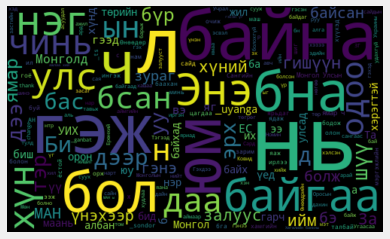

In [78]:
# Plot the word cloud
allWords = ' '.join([tweets for tweets in df['Tweets']])
wordCloud = WordCloud(width = 500, height=300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Create a function to compare the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Show the dataframe
df

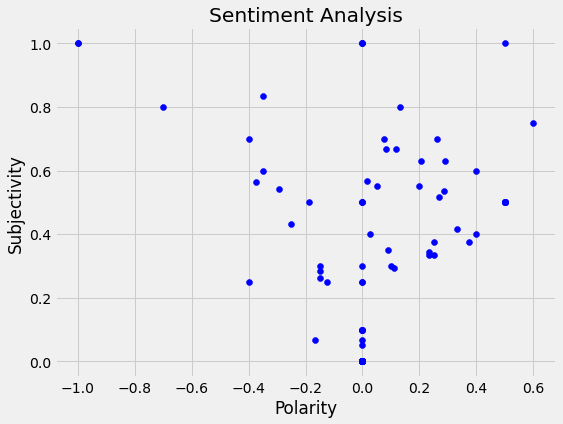

In [43]:
# Plot the polarty and subjectivity
plt.figure(figsize = (8, 6))
for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [6]:
# Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

ptweets

AttributeError: 'DataFrame' object has no attribute 'Analysis'

## Get the data

In [4]:
 # Variables that contain user credentials to access Twitter API

API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"

# # Create the authentification object
# authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

# # Set the access token
# authenticate.set_access_token(Bearer_Token)

# # Create the API object while passing in the auth information
# api = tweepy.API(authenticate, wait_on_rate_limit = True)

authenticate = tweepy.OAuthHandler(API_Key, API_Key_Secret)

authenticate.set_access_token(Access_Token, Access_Token_Secret)

# Create the API object while in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

C:\Users\ollie\anaconda3\lib\site-packages\tweepy\auth.py:120: DeprecationWarning: OAuthHandler is deprecated; use OAuth1UserHandler instead.
  warnings.warn(


In [5]:
import base64
import requests
# returns a bearer_header to attach to requests to the Twitter api v2 enpoints which are 
# not yet supported by tweepy 
def get_bearer_header():
    API_Key = "yQYG1NxWXVJzFMGzYLPUAyKCe"
    API_Key_Secret = "epUQTwaCkIkKENvJw5LpcgPk8cuS54tqHQCrlGiA3mzLvrpIgP" 
    Access_Token = "1415883671685398530-1FwkU7DMkYfLXyJ1tUGpZoi2te8aKr"
    Access_Token_Secret = "QoLDp1nnWT5hiHuUjH118ZaQ9Ja4AWbjhl4uj9Larq5I5"
    bearer_token = "AAAAAAAAAAAAAAAAAAAAAHrEbQEAAAAAeEN3uxEiSGEnxvCwGhOZCSDj%2Fe0%3DWddtocQJEsg65lAZeVzvn6IW7sZDOBbMKk50CplYpzdVZyjpQl"
    bearer_header = {
       'Accept-Encoding': 'gzip',
       'Authorization': 'Bearer {}'.format(bearer_token),
       'oauth_consumer_key': API_Key
       }
    return bearer_header

def makeTwitterQuery(query, fields, amount):
    uri = 'https://api.twitter.com/2/tweets/search/recent?'
    params = {'query': query,
       'tweet.fields': fields,
        'max_results':str(amount)
        #'tweet.fields':'replies'
       }
    bearer_header = get_bearer_header()
    resp = requests.get(uri, headers=bearer_header, params=params)
    return resp.json()

def getTweets(account_name, amount):
    query = f'from:{account_name}'
    gett = makeTwitterQuery(query, 'text,conversation_id', amount)
    return gett

def getConversation(conversation_id, amount):
    query = f'conversation_id:{conversation_id}'
    gett = makeTwitterQuery(query, 'text,conversation_id',amount)
    return gett

data = getTweets('jordanbpeterson', 50)
print(len(data['data']))
conversations = []
for datum in data['data']:
    conversations.append(getConversation(datum['conversation_id'], 50))

19


In [10]:
for conversation in conversations:
    if 'data' in conversation:
        pass
    else:
        conversation['data'] = []

df = pd.DataFrame([datum['text'] for datum in data['data']], columns=['RawTweet'])
df['TweetText'] = df['RawTweet']
df['RawConversations'] = df['RawTweet']
df['ConversationObjects'] = df['RawTweet']

df['TweetText'] = [datum['text'] for datum in data['data']]
df['RawConversations'] = [conversation['data'] for conversation in conversations]

df
# df['Raw text'] = df['Raw tweets'].apply(lambda tweet: tweet.full_text)
# df['Raw retweets'] = df['Raw tweets'].apply(lambda tweet: Retweets(tweet))

,RawTweet,TweetText,RawConversations,ConversationObjects
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",Treasures of art and intellect should be an in...
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...","The more people sort themselves out, the more ..."
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",A plan is better than no plan.\n\nFrom the Bri...
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",Posting on Parler - https://t.co/GdTSBLipaw
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...","You may think, “I can’t give them up.” Not onl..."
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...","If you’re trying to get your life together, an..."
6,But a friend is also someone you can tell good...,But a friend is also someone you can tell good...,"[{'conversation_id': '1518988117361020930', 'i...",But a friend is also someone you can tell good...
7,A friend is someone you can tell bad news to.\...,A friend is someone you can tell bad news to.\...,"[{'conversation_id': '1518988117361020930', 'i...",A friend is someone you can tell bad news to.\...
8,"In this episode, @DouglasKMurray and I discuss...","In this episode, @DouglasKMurray and I discuss...","[{'conversation_id': '1518640334175092736', 'i...","In this episode, @DouglasKMurray and I discuss..."
9,"It's hard to tell the truth, the full truth. ⁣...","It's hard to tell the truth, the full truth. ⁣...","[{'conversation_id': '1518636452766224387', 'i...","It's hard to tell the truth, the full truth. ⁣..."


In [7]:
class DynConversation():
    pass

def getDynamicConversation(conversation):
    # Make dynamic retweeT
    dynConversation = DynConversation()
    dynConversation.rawTextList = []
    if (conversation['data'] is not None):
        for x in conversation['data']:
            textie = x['text']
            dynConversation.rawTextList.append(x['text'])
    else:
        dynConversation.rawTextList = None
    return dynConversation
df['ConversationObjects'] = [getDynamicConversation(conversation) for conversation in conversations]

In [8]:
df

,RawTweet,TweetText,RawConversations,ConversationObjects
0,Treasures of art and intellect should be an in...,Treasures of art and intellect should be an in...,"[{'conversation_id': '1519642531612528646', 'i...",<__main__.DynConversation object at 0x00000187...
1,"The more people sort themselves out, the more ...","The more people sort themselves out, the more ...","[{'conversation_id': '1519396778067517441', 'i...",<__main__.DynConversation object at 0x00000187...
2,A plan is better than no plan.\n\nFrom the Bri...,A plan is better than no plan.\n\nFrom the Bri...,"[{'conversation_id': '1519336770952998913', 'i...",<__main__.DynConversation object at 0x00000187...
3,Posting on Parler - https://t.co/GdTSBLipaw,Posting on Parler - https://t.co/GdTSBLipaw,"[{'conversation_id': '1518991673984012288', 'i...",<__main__.DynConversation object at 0x00000187...
4,"You may think, “I can’t give them up.” Not onl...","You may think, “I can’t give them up.” Not onl...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynConversation object at 0x00000187...
5,"If you’re trying to get your life together, an...","If you’re trying to get your life together, an...","[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynConversation object at 0x00000187...
6,But a friend is also someone you can tell good...,But a friend is also someone you can tell good...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynConversation object at 0x00000187...
7,A friend is someone you can tell bad news to.\...,A friend is someone you can tell bad news to.\...,"[{'conversation_id': '1518988117361020930', 'i...",<__main__.DynConversation object at 0x00000187...
8,"In this episode, @DouglasKMurray and I discuss...","In this episode, @DouglasKMurray and I discuss...","[{'conversation_id': '1518640334175092736', 'i...",<__main__.DynConversation object at 0x00000187...
9,"It's hard to tell the truth, the full truth. ⁣...","It's hard to tell the truth, the full truth. ⁣...","[{'conversation_id': '1518636452766224387', 'i...",<__main__.DynConversation object at 0x00000187...


50


In [11]:
print(conversations[10]['data'])

[{'conversation_id': '1518242427378806785', 'id': '1519609621429719041', 'text': "@jordanbpeterson REPENT,EVIL POLICE &amp; CHANGE WHAT YOU'RE DOING,AS THE ARC-ANGELS SEE &amp; RECORD WHAT YOU COMMIT,IN THE BOOK OF LIFE &amp; YOUR LOVED ONES WATCH YOUR EVIL ACTS FROM https://t.co/8RmF6MmtmS JESUS SHOWS THEM TRUTH!! CAN'T KILL ANGELS LOL"}, {'conversation_id': '1518242427378806785', 'id': '1519609126040481792', 'text': "@jordanbpeterson WOW,I WOULDN'T WANT TO BE NAMED IN THE ABUSE OF PASTOR ARTUR!! JESUS HAS THE NAMES OF ALL THE EVIL ONES &amp; THEY WILL TREMBLE WITH FEAR,AT HIS PRESENCE &amp; NEVER SEE THEIR LOVED ONES IN HEAVEN.TRUE WORDS"}, {'conversation_id': '1518242427378806785', 'id': '1519103529054621699', 'text': '@jordanbpeterson God bless the HS teachers I had in the 80’s. Mr Hughes wouldn’t allow us to parrot. We had discussions of current events and, tho opinions may remain the same: he helped us see valid points of others. And Mrs. Jacobs didn’t let anyone slide when it ca

In [8]:
df = pd.DataFrame([tweet for tweet in posts], columns=['Raw tweets'])
df['Raw text'] = df['Raw tweets'].apply(lambda tweet: tweet.full_text)
df['Raw retweets'] = df['Raw tweets'].apply(lambda tweet: Retweets(tweet))

## <span style="background-color: #FFFF00">Please don't click on cell above unless absolutely necessary - it will run for 30 minutes at least!</span>

### Creating dynamic object

In [128]:
class DynRetweets():
    pass

class DynRetweet():
    pass

def getDynamicRetweets(oldRetweets):
    # Make dynamic retweeT
    dynRetweetsList = []
    for i in range(0, len(oldRetweets.objTweets)):
        oldRetweet = oldRetweets.objTweets[i] 
        
        dynRetweet = DynRetweet()
        dynRetweet.raw = oldRetweet.raw
        dynRetweet.text = oldRetweet.text
        dynRetweetsList.append(dynRetweet)
    return(dynRetweetsList)

df['RetweetObjects'] = df['Raw retweets'].apply(lambda retweets: getDynamicRetweets(retweets))
print(df['RetweetObjects'][0][1].text)
df

RT @jordanbpeterson: "a new study"


,Raw tweets,Raw text,Raw retweets,RetweetObjects,cleanedText,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,lemma_tokens_extended
0,Status(_api=<tweepy.api.API object at 0x000001...,"""a new study"" https://t.co/jslyV0HTey",<__main__.Retweets object at 0x0000017670423700>,[<__main__.DynRetweet object at 0x000001764FC6...,"""a new study""",0.454545,0.136364,"[""a, new, study""]","""a new study""","[new, study]",new study,"[new, study, new, study, new, study, new, stud...","[new, study, new, study, new, study, new, stud..."
1,Status(_api=<tweepy.api.API object at 0x000001...,"RT @bdomenech: Democrats, I have terrible news...",<__main__.Retweets object at 0x00000176411C89A0>,[],": Democrats, I have terrible news for you. His...",1.000000,-1.000000,"[:, democrats,, terrible, news, you., hispanic...",": democrats, terrible news you. hispanics repu...","[democrat, terrible, news, hispanic, republica...",democrat terrible news hispanic republican min...,"[democrat, terrible, news, hispanic, republica...","[democrat, terrible, news, hispanic, republica..."
2,Status(_api=<tweepy.api.API object at 0x000001...,They both have orange hair (except @PierrePoil...,<__main__.Retweets object at 0x000001767CC2A910>,[<__main__.DynRetweet object at 0x000001764F97...,They both have orange hair (except )!,0.000000,0.000000,"[orange, hair, (except, )!]",orange hair (except )!,"[orange, hair]",orange hair,"[orange, hair, orange, hair, orange, hair, ora...","[orange, hair, orange, hair, orange, hair, ora..."
3,Status(_api=<tweepy.api.API object at 0x000001...,Societies that actively devalue motherhood hav...,<__main__.Retweets object at 0x000001764151EDC0>,[<__main__.DynRetweet object at 0x000001764F97...,Societies that actively devalue motherhood hav...,0.800000,-0.316667,"[societies, actively, devalue, motherhood, irr...",societies actively devalue motherhood irredeem...,"[society, actively, devalue, motherhood, irred...",society actively devalue motherhood irredeemab...,"[society, actively, devalue, motherhood, irred...","[society, actively, devalue, motherhood, irred..."
4,Status(_api=<tweepy.api.API object at 0x000001...,"""help Canadians"" https://t.co/j1e95kf0TG",<__main__.Retweets object at 0x0000017641637970>,[<__main__.DynRetweet object at 0x000001764F97...,"""help Canadians""",0.000000,0.000000,"[""help, canadians""]","""help canadians""","[help, canadian]",help canadian,"[help, canadian, help, canadian, help, canadia...","[help, canadian, help, canadian, help, canadia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Status(_api=<tweepy.api.API object at 0x000001...,And that's a historic moment.,<__main__.Retweets object at 0x000001764E56AFD0>,[<__main__.DynRetweet object at 0x000001765328...,And that's a historic moment.,0.000000,0.000000,"[that's, historic, moment.]",that's historic moment.,"[historic, moment]",historic moment,"[historic, moment, historic, moment, historic,...","[historic, moment, historic, moment, historic,..."
216,Status(_api=<tweepy.api.API object at 0x000001...,I don't know what a woman is either but appare...,<__main__.Retweets object at 0x000001764F668310>,[<__main__.DynRetweet object at 0x000001765329...,I don't know what a woman is either but appare...,0.350000,0.050000,"[don't, know, woman, apparently, appointed, su...",don't know woman apparently appointed supreme ...,"[know, woman, apparently, appoint, supreme, co...",know woman apparently appoint supreme court,"[know, woman, apparently, appoint, supreme, co...","[know, woman, apparently, appoint, supreme, co..."
217,Status(_api=<tweepy.api.API object at 0x000001...,RT @anthonyfurey: Informative thread. Let’s ho...,<__main__.Retweets object at 0x000001764F6B59A0>,[],: Informative thread. Let’s hope the Ontario g...,0.600000,0.200000,"[:, informative, thread., let’s, hope, ontario...",: informative thread. let’s hope ontario gover...,"[informative, thread, let, hope, ontario, gove...",informative thread let

In [12]:
def applyToConversationObj(newField, function, fromAttr):
    for atRow in range(0, len(df['ConversationObjects'])):
        rawRetweets = df['ConversationObjects'][atRow]
        for atRetweet in range(0, len(rawRetweets)):
            value = function(getattr(df['ConversationObjects'][atRow][atRetweet], fromAttr))
            setattr(df['ConversationObjects'][atRow][atRetweet], newField, value)

In [152]:
df['Raw retweets'][3].objTweets[0].text
print(df['Raw retweets'][2].objTweets[0].raw)

Status(_api=<tweepy.api.API object at 0x0000017670461340>, _json={'created_at': 'Thu Apr 14 00:10:50 +0000 2022', 'id': 1514395719939104771, 'id_str': '1514395719939104771', 'text': 'RT @jordanbpeterson: They both have orange hair (except @PierrePoilievre )!', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'jordanbpeterson', 'name': 'Dr Jordan B Peterson', 'id': 95092020, 'id_str': '95092020', 'indices': [3, 19]}, {'screen_name': 'PierrePoilievre', 'name': 'Pierre Poilievre', 'id': 242827267, 'id_str': '242827267', 'indices': [56, 72]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 34119879, 'id_str': '34119879', 'name': 'RedEyedVinithian', 'screen_name': 'Vinithian', 'location': '', 'description':

## Deleting emojis, etc. (for the retweets to the first tweet)

In [53]:
# Create a function to clean the tweets
def deleteSpecialSymbols(text):
    # Substitute certain patterns in the tweets
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    
    return text

def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https\S+', '', text)
    return text

def getCleanText(text):
    text = deleteSpecialSymbols(text)
    text = give_emoji_free_text(text)
    text = url_free_text(text)
    return text

# Cleaning the text of tweets
df['cleanedText'] = df['Raw text'].apply(getCleanText)


# Cleaning the retweets
applyToRetweetAs('cleanedText', getCleanText, 'text')

### Get the subjectivity data

In [ ]:
#[item for sublist in t for item in sublist]

In [55]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['cleanedText'].apply(getSubjectivity)
df['Polarity'] = df['cleanedText'].apply(getPolarity)

df

applyToRetweetAs('Subjectivity', getSubjectivity, 'cleanedText')
applyToRetweetAs('Polarity', getPolarity, 'cleanedText')

### Tokenization

In [97]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)



def tokenize(dfColumn):
    tokens = []

#     tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
#     #tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
#     tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $
#     tokens = tokens.strip(',') # TESTING THIS LINE
#     tokens = tokens.strip('?') # TESTING THIS LINE
#     tokens = tokens.strip('!') # TESTING THIS LINE
#     tokens = tokens.strip("'") # TESTING THIS LINE
#     tokens = tokens.strip(".") # TESTING THIS LINE
    if isinstance(dfColumn, str):
        doc_tokens = []
        tokens = tokenizer(dfColumn) 
        for token in tokens:
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())   
        return (doc_tokens)
    else:
        for doc in tokenizer.pipe(dfColumn, batch_size=500):
            doc_tokens = []    
            for token in doc: 
                if token.text.lower() not in STOP_WORDS:
                    doc_tokens.append(token.text.lower())   
            tokens.append(doc_tokens)
        return tokens

#Tokenize the tweets
df['tokens'] = tokenize(df['cleanedText'])

# Cleaning the retweets
applyToRetweetAs('tokens', tokenize, 'cleanedText')

In [63]:
df

,Raw tweets,Raw text,Raw retweets,RetweetObjects,cleanedText,Subjectivity,Polarity,tokens
0,Status(_api=<tweepy.api.API object at 0x000001...,"""a new study"" https://t.co/jslyV0HTey",<__main__.Retweets object at 0x0000017670423700>,[<__main__.DynRetweet object at 0x000001764FAA...,"""a new study""",0.454545,0.136364,"[""a, new, study""]"
1,Status(_api=<tweepy.api.API object at 0x000001...,"RT @bdomenech: Democrats, I have terrible news...",<__main__.Retweets object at 0x00000176411C89A0>,[],": Democrats, I have terrible news for you. His...",1.000000,-1.000000,"[:, democrats,, terrible, news, you., hispanic..."
2,Status(_api=<tweepy.api.API object at 0x000001...,They both have orange hair (except @PierrePoil...,<__main__.Retweets object at 0x000001767CC2A910>,[<__main__.DynRetweet object at 0x000001764FC2...,They both have orange hair (except )!,0.000000,0.000000,"[orange, hair, (except, )!]"
3,Status(_api=<tweepy.api.API object at 0x000001...,Societies that actively devalue motherhood hav...,<__main__.Retweets object at 0x000001764151EDC0>,[<__main__.DynRetweet object at 0x000001764FC2...,Societies that actively devalue motherhood hav...,0.800000,-0.316667,"[societies, actively, devalue, motherhood, irr..."
4,Status(_api=<tweepy.api.API object at 0x000001...,"""help Canadians"" https://t.co/j1e95kf0TG",<__main__.Retweets object at 0x0000017641637970>,[<__main__.DynRetweet object at 0x000001764FA4...,"""help Canadians""",0.000000,0.000000,"[""help, canadians""]"
...,...,...,...,...,...,...,...,...
215,Status(_api=<tweepy.api.API object at 0x000001...,And that's a historic moment.,<__main__.Retweets object at 0x000001764E56AFD0>,[<__main__.DynRetweet object at 0x000001764FC8...,And that's a historic moment.,0.000000,0.000000,"[that's, historic, moment.]"
216,Status(_api=<tweepy.api.API object at 0x000001...,I don't know what a woman is either but appare...,<__main__.Retweets object at 0x000001764F668310>,[<__main__.DynRetweet object at 0x000001764FC8...,I don't know what a woman is either but appare...,0.350000,0.050000,"[don't, know, woman, apparently, appointed, su..."
217,Status(_api=<tweepy.api.API object at 0x000001...,RT @anthonyfurey: Informative thread. Let’s ho...,<__main__.Retweets object at 0x000001764F6B59A0>,[],: Informative thread. Let’s hope the Ontario g...,0.600000,0.200000,"[:, informative, thread., let’s, hope, ontario..."
218,Status(_api=<tweepy.api.API object at 0x000001...,Our national broadcaster doing its best to dem...,<__main__.Retweets object at 0x000001764F67E700>,[<__main__.DynRetweet object at 0x000001764FC8...,Our national broadcaster doing its best to dem...,0.300000,1.000000,"[national, broadcaster, best, demoralize, defe..."


### Lemmatization
Convert "Studying" into "Study", "Meeting" into "meet", "better" and "best" into "good"

In [98]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def toString(tokens):
    return ' '.join(tokens)
    
applyToRetweetAs('tokens_back_to_text', toString, 'tokens')

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
applyToRetweetAs('lemmas', get_lemmas, 'tokens_back_to_text')

In [109]:
print(df['RetweetObjects'][0][6].cleanedText)
##print(df['lemma_tokens_extended'][3])

: "a new study"


In [99]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]
applyToRetweetAs('lemmas_back_to_text', toString, 'lemmas')

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removes @mentions
    text = re.sub(r'#', '', text) #Removing the # symbol
    text = re.sub(r'rt[\s]+', '', text) #Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) #Will remove the hyperlinks
    
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    #tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
applyToRetweetAs('lemma_tokens', tokenize, 'lemmas_back_to_text')

<>:23: DeprecationWarning: invalid escape sequence \$
<>:23: DeprecationWarning: invalid escape sequence \$
C:\Users\ollie\AppData\Local\Temp/ipykernel_3048/2984802385.py:23: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', tokens) # Remove @ ! $


In [100]:
df

,Raw tweets,Raw text,Raw retweets,RetweetObjects,cleanedText,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,lemma_tokens_extended
0,Status(_api=<tweepy.api.API object at 0x000001...,"""a new study"" https://t.co/jslyV0HTey",<__main__.Retweets object at 0x0000017670423700>,[<__main__.DynRetweet object at 0x000001764FAA...,"""a new study""",0.454545,0.136364,"[""a, new, study""]","""a new study""","[new, study]",new study,"[new, study]","[new, study, new, study, new, study, new, stud..."
1,Status(_api=<tweepy.api.API object at 0x000001...,"RT @bdomenech: Democrats, I have terrible news...",<__main__.Retweets object at 0x00000176411C89A0>,[],": Democrats, I have terrible news for you. His...",1.000000,-1.000000,"[:, democrats,, terrible, news, you., hispanic...",": democrats, terrible news you. hispanics repu...","[democrat, terrible, news, hispanic, republica...",democrat terrible news hispanic republican min...,"[democrat, terrible, news, hispanic, republica...","[democrat, terrible, news, hispanic, republica..."
2,Status(_api=<tweepy.api.API object at 0x000001...,They both have orange hair (except @PierrePoil...,<__main__.Retweets object at 0x000001767CC2A910>,[<__main__.DynRetweet object at 0x000001764FC2...,They both have orange hair (except )!,0.000000,0.000000,"[orange, hair, (except, )!]",orange hair (except )!,"[orange, hair]",orange hair,"[orange, hair]","[orange, hair, orange, hair, orange, hair, ora..."
3,Status(_api=<tweepy.api.API object at 0x000001...,Societies that actively devalue motherhood hav...,<__main__.Retweets object at 0x000001764151EDC0>,[<__main__.DynRetweet object at 0x000001764FC2...,Societies that actively devalue motherhood hav...,0.800000,-0.316667,"[societies, actively, devalue, motherhood, irr...",societies actively devalue motherhood irredeem...,"[society, actively, devalue, motherhood, irred...",society actively devalue motherhood irredeemab...,"[society, actively, devalue, motherhood, irred...","[society, actively, devalue, motherhood, irred..."
4,Status(_api=<tweepy.api.API object at 0x000001...,"""help Canadians"" https://t.co/j1e95kf0TG",<__main__.Retweets object at 0x0000017641637970>,[<__main__.DynRetweet object at 0x000001764FA4...,"""help Canadians""",0.000000,0.000000,"[""help, canadians""]","""help canadians""","[help, canadian]",help canadian,"[help, canadian]","[help, canadian, help, canadian, help, canadia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Status(_api=<tweepy.api.API object at 0x000001...,And that's a historic moment.,<__main__.Retweets object at 0x000001764E56AFD0>,[<__main__.DynRetweet object at 0x000001764FC8...,And that's a historic moment.,0.000000,0.000000,"[that's, historic, moment.]",that's historic moment.,"[historic, moment]",historic moment,"[historic, moment]","[historic, moment, historic, moment, historic,..."
216,Status(_api=<tweepy.api.API object at 0x000001...,I don't know what a woman is either but appare...,<__main__.Retweets object at 0x000001764F668310>,[<__main__.DynRetweet object at 0x000001764FC8...,I don't know what a woman is either but appare...,0.350000,0.050000,"[don't, know, woman, apparently, appointed, su...",don't know woman apparently appointed supreme ...,"[know, woman, apparently, appoint, supreme, co...",know woman apparently appoint supreme court,"[know, woman, apparently, appoint, supreme, co...","[know, woman, apparently, appoint, supreme, co..."
217,Status(_api=<tweepy.api.API object at 0x000001...,RT @anthonyfurey: Informative thread. Let’s ho...,<__main__.Retweets object at 0x000001764F6B59A0>,[],: Informative thread. Let’s hope the Ontario g...,0.600000,0.200000,"[:, informative, thread., let’s, hope, ontario...",: informative thread. let’s hope ontario gover...,"[informative, thread, let, hope, ontario, gove...",informative thread let hope ontario government...,"[informative, thread, let, hope, ontario, gove...","[informative, thread, let, hope, ontario, gove..."
218,

### Topic Modeling (Linear Discriminant Analysis)

In [69]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print((id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

Dictionary(1055 unique tokens: ['new', 'study', 'democrat', 'hispanic', 'minute']...)
248
------ Topic 0 ------
look people bank help expect university person big modern fact

------ Topic 1 ------
man yes work year price canada party useful real life

------ Topic 2 ------
people good thing time world think work normal grow truly

------ Topic 3 ------
stephen oh go hicks postmodernism think right open need work

------ Topic 4 ------
idea canadian woman peterson post social artist wing shock fun



In [101]:
# Add retweet lemmas into the lemma_tokens
df['lemma_tokens_extended'] = df['lemma_tokens']

for atRow in range(0, len(df['lemma_tokens_extended'])):
        rawRetweets = df['RetweetObjects'][atRow]
        for atRetweet in range(0, len(rawRetweets)):
            retweetLemmas = df['RetweetObjects'][atRow][atRetweet].lemma_tokens
            for x in retweetLemmas:
                df['lemma_tokens_extended'][atRow].append(x)

In [102]:
df

,Raw tweets,Raw text,Raw retweets,RetweetObjects,cleanedText,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,lemma_tokens_extended
0,Status(_api=<tweepy.api.API object at 0x000001...,"""a new study"" https://t.co/jslyV0HTey",<__main__.Retweets object at 0x0000017670423700>,[<__main__.DynRetweet object at 0x000001764FAA...,"""a new study""",0.454545,0.136364,"[""a, new, study""]","""a new study""","[new, study]",new study,"[new, study, new, study, new, study, new, stud...","[new, study, new, study, new, study, new, stud..."
1,Status(_api=<tweepy.api.API object at 0x000001...,"RT @bdomenech: Democrats, I have terrible news...",<__main__.Retweets object at 0x00000176411C89A0>,[],": Democrats, I have terrible news for you. His...",1.000000,-1.000000,"[:, democrats,, terrible, news, you., hispanic...",": democrats, terrible news you. hispanics repu...","[democrat, terrible, news, hispanic, republica...",democrat terrible news hispanic republican min...,"[democrat, terrible, news, hispanic, republica...","[democrat, terrible, news, hispanic, republica..."
2,Status(_api=<tweepy.api.API object at 0x000001...,They both have orange hair (except @PierrePoil...,<__main__.Retweets object at 0x000001767CC2A910>,[<__main__.DynRetweet object at 0x000001764FC2...,They both have orange hair (except )!,0.000000,0.000000,"[orange, hair, (except, )!]",orange hair (except )!,"[orange, hair]",orange hair,"[orange, hair, orange, hair, orange, hair, ora...","[orange, hair, orange, hair, orange, hair, ora..."
3,Status(_api=<tweepy.api.API object at 0x000001...,Societies that actively devalue motherhood hav...,<__main__.Retweets object at 0x000001764151EDC0>,[<__main__.DynRetweet object at 0x000001764FC2...,Societies that actively devalue motherhood hav...,0.800000,-0.316667,"[societies, actively, devalue, motherhood, irr...",societies actively devalue motherhood irredeem...,"[society, actively, devalue, motherhood, irred...",society actively devalue motherhood irredeemab...,"[society, actively, devalue, motherhood, irred...","[society, actively, devalue, motherhood, irred..."
4,Status(_api=<tweepy.api.API object at 0x000001...,"""help Canadians"" https://t.co/j1e95kf0TG",<__main__.Retweets object at 0x0000017641637970>,[<__main__.DynRetweet object at 0x000001764FA4...,"""help Canadians""",0.000000,0.000000,"[""help, canadians""]","""help canadians""","[help, canadian]",help canadian,"[help, canadian, help, canadian, help, canadia...","[help, canadian, help, canadian, help, canadia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Status(_api=<tweepy.api.API object at 0x000001...,And that's a historic moment.,<__main__.Retweets object at 0x000001764E56AFD0>,[<__main__.DynRetweet object at 0x000001764FC8...,And that's a historic moment.,0.000000,0.000000,"[that's, historic, moment.]",that's historic moment.,"[historic, moment]",historic moment,"[historic, moment, historic, moment, historic,...","[historic, moment, historic, moment, historic,..."
216,Status(_api=<tweepy.api.API object at 0x000001...,I don't know what a woman is either but appare...,<__main__.Retweets object at 0x000001764F668310>,[<__main__.DynRetweet object at 0x000001764FC8...,I don't know what a woman is either but appare...,0.350000,0.050000,"[don't, know, woman, apparently, appointed, su...",don't know woman apparently appointed supreme ...,"[know, woman, apparently, appoint, supreme, co...",know woman apparently appoint supreme court,"[know, woman, apparently, appoint, supreme, co...","[know, woman, apparently, appoint, supreme, co..."
217,Status(_api=<tweepy.api.API object at 0x000001...,RT @anthonyfurey: Informative thread. Let’s ho...,<__main__.Retweets object at 0x000001764F6B59A0>,[],: Informative thread. Let’s hope the Ontario g...,0.600000,0.200000,"[:, informative, thread., let’s, hope, ontario...",: informative thread. let’s hope ontario gover...,"[informative, thread, let, hope, ontario, gove...",informative thread let

In [90]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens_extended'])
print((id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens_extended']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

Dictionary(1082 unique tokens: ['new', 'study', 'democrat', 'hispanic', 'minute']...)
249
------ Topic 0 ------
need fun let liberal civil war people new say green

------ Topic 1 ------
work well canadian utterly truly go society look oh post

------ Topic 2 ------
thing idea yes right late podcast planet absolutely left way

------ Topic 3 ------
people expect think lot artist time bloody stephen open order

------ Topic 4 ------
good far thank oh jordan woman soul know question peterson



### Computing Perplexity

In [446]:
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts = df['lemma_tokens'], dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.0102803771615365

Coherence Score:  0.5816888009521685


In [341]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

C:\Users\ollie\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.100640  0.016128       1        1  21.306183
1      0.080082 -0.106283       2        1  20.538778
2     -0.074427 -0.007807       3        1  20.332767
0      0.014636 -0.025602       4        1  20.245416
3      0.080349  0.123563       5        1  17.576855, topic_info=            Term       Freq      Total Category  logprob  loglift
213        biden  19.000000  19.000000  Default  30.0000  30.0000
15          time  11.000000  11.000000  Default  29.0000  29.0000
67        gender  11.000000  11.000000  Default  28.0000  28.0000
228         know  11.000000  11.000000  Default  27.0000  27.0000
345      million   7.000000   7.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
438         elon   2.437863   5.549370   Topic5  -5.3592   0.9160
55         great   2.510828   6.343623   Topic5  -5.3297   0.8117
21           new   3.467961  20.715482   Topic5  -5.0067  -0.0487
432  palestinian   2.512683   8.746794   Topic5  -5.3289   0.4913
99          year   2.547507  26.332852   Topic5  -5.3152  -0.5971

[316 rows x 6 columns], token_table=      Topic      Freq Term
term                      
349       5  0.845756   11
344       1  0.250575    3
344       2  0.751724    3
308       3  0.834267  4th
499       1  0.278775    5
...     ...       ...  ...
726       3  0.250544    👏
726       4  0.751633    👏
221       3  0.469359    🚨
221       4  0.469359    🚨
723       3  0.834269    🤯

[502 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 1, 4])

In [68]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

id = 8
print('\n')
print(df['Tweets'][id])
print(df['Polarity'][id])
vector = base_model[id2word.doc2bow(df['lemma_tokens'][id])]
print(vector)

NameError: name 'topics' is not defined

In [447]:
df['Classification'] = df['Tweets']
df['Classification_strength'] = df['Tweets']

In [448]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

for row_id in range(0, len(df)):
    vector = base_model[id2word.doc2bow(df['lemma_tokens'][row_id])]
    
    # Get the topic
    max = 0
    index = 0
    i = 0
    # Get the maximum
    for topic in vector:
        if topic[1]>max:
            max = topic[1]
            index = i
        i = i+1
    df['Classification'][row_id] = "Topic "+str(index)
    df['Classification_strength'][row_id] = max

------ Topic 0 ------
thing good way life podcast child well go late ticket

------ Topic 1 ------
world year people right real order speak structure look matter

------ Topic 2 ------
expect people say good grow work person turn increase food

------ Topic 3 ------
know man work woman time thing learn understand conversation people

------ Topic 4 ------
think people post mean social need equity address parler national



C:\Users\ollie\AppData\Local\Temp/ipykernel_1068/299263836.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification'][row_id] = "Topic "+str(index)
C:\Users\ollie\AppData\Local\Temp/ipykernel_1068/299263836.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification_strength'][row_id] = max


In [413]:
df

,Tweets,Subjectivity,Polarity,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens,Classification,Classification_strength
0,"By May of 2021, more than 115,000 frontline wo...",0.250000,0.083333,"[2021,, 115,000, frontline, workers, died, tak...","2021, 115,000 frontline workers died taking ca...","[2021, 115,000, frontline, worker, die, take, ...","2021 115,000 frontline worker die take care co...","[2021, 115000, frontline, worker, die, take, c...",Topic 0,0.949285
1,": To make COVID-19 TheLastPandemic, We need in...",0.000000,0.000000,"[:, covid-19, thelastpandemic,, need, investme...",": covid-19 thelastpandemic, need investments i...","[covid-19, thelastpandemic, need, investment, ...",covid-19 thelastpandemic need investment ✔ ️ d...,"[covid19, thelastpandemic, need, investment, ✔...",Topic 3,0.93168
2,I'm excited to take the stage at TED2022 and s...,0.408333,0.187500,"[excited, stage, ted2022, share, plan, covid-1...",excited stage ted2022 share plan covid-19 pand...,"[excited, stage, ted2022, share, plan, covid-1...",excited stage ted2022 share plan covid-19 pand...,"[excited, stage, ted2022, share, plan, covid19...",Topic 2,0.898519
3,I recently had a chance to check out some of t...,0.587500,0.225000,"[recently, chance, check, latest, devices, exp...",recently chance check latest devices experienc...,"[recently, chance, check, late, device, experi...",recently chance check late device experience a...,"[recently, chance, check, late, device, experi...",Topic 2,0.926891
4,: Ever wonder whether foundation partners give...,0.900000,0.600000,"[:, wonder, foundation, partners, honest, feed...",: wonder foundation partners honest feedback l...,"[wonder, foundation, partner, honest, feedback...",wonder foundation partner honest feedback lead...,"[wonder, foundation, partner, honest, feedback...",Topic 0,0.564559
...,...,...,...,...,...,...,...,...,...,...
515,: “Only those feigning blindness fail to see t...,0.650000,-0.250000,"[:, “only, feigning, blindness, fail, body, wo...",": “only feigning blindness fail body work are,...","[feign, blindness, fail, body, work, work, body]",feign blindness fail body work work body,"[feign, blindness, fail, body, work, work, body]",Topic 0,0.865805
516,: Juneteenth recognizes &amp; celebrates Black...,0.433333,-0.208333,"[:, juneteenth, recognizes, celebrates, black,...",: juneteenth recognizes celebrates black peopl...,"[juneteenth, recognize, celebrate, black, peop...",juneteenth recognize celebrate black people fr...,"[juneteenth, recognize, celebrate, black, peop...",Topic 1,0.687294
517,_org: It's time to end the silence about our h...,0.000000,0.000000,"[_org:, time, end, silence, history, racial, i...",_org: time end silence history racial injustic...,"[org, time, end, silence, history, racial, inj...",org time end silence history racial injustice ...,"[org, time, end, silence, history, racial, inj...",Topic 1,0.910234
518,: Proud to share my thoughts in ’s “injustice ...,0.800000,0.533333,"[:, proud, share, thoughts, “injustice, issue”...",: proud share thoughts “injustice issue” (and ...,"[proud, share, thought, injustice, issue, belo...",proud share thought injustice issue beloved yo...,"[proud, share, thought, injustice, issue, belo...",Topic 2,0.88406


------ Topic 0 ------
thing good way life podcast child well go late ticket

------ Topic 1 ------
world year people right real order speak structure look matter

------ Topic 2 ------
expect people say good grow work person turn increase food

------ Topic 3 ------
know man work woman time thing learn understand conversation people

------ Topic 4 ------
think people post mean social need equity address parler national



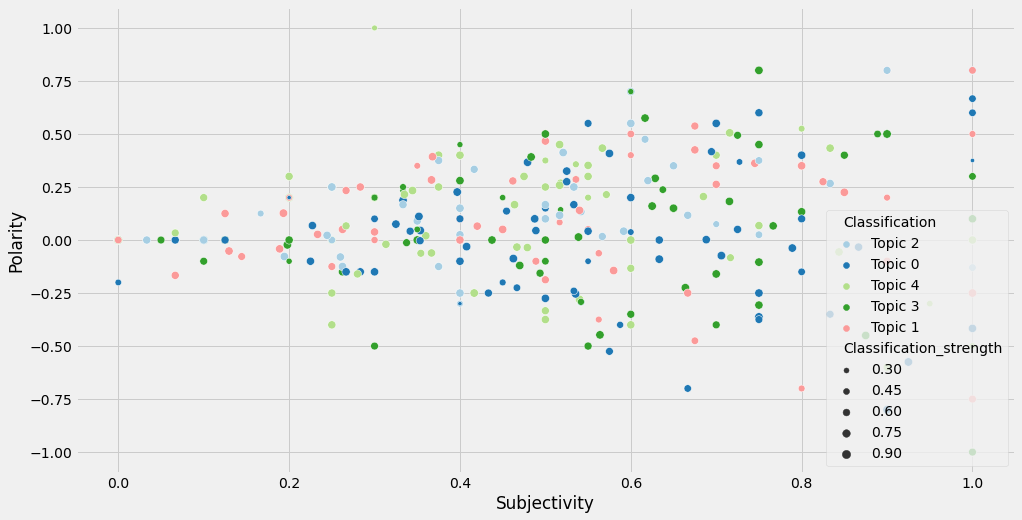

In [449]:
sns.color_palette("Paired")
plt.figure(figsize=(15,8))

ax = sns.scatterplot(x="Subjectivity", y="Polarity", data=df, hue="Classification", size = "Classification_strength", palette="Paired")

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")